# MLP scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


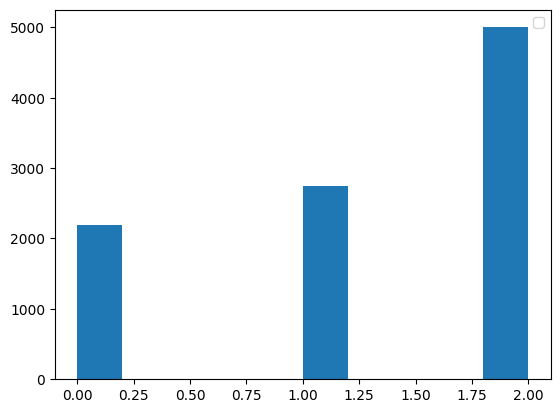

In [3]:
plt.hist([dfTraining['ae_cl']])
plt.legend()
plt.show()

In [4]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)


In [5]:
model = LinearRegression()
def get_coeff(row, model=model):
    # Select only relevant columns
    row = row.loc["rv1":"rv1500"]
    # Drop NaN values
    row = row.dropna()
    if len(row) > 1:  # Check if there are enough data points for regression
        X = np.arange(len(row)).reshape(-1, 1)
        y = row.values.reshape(-1, 1)
        model.fit(X, y)
        slope = model.coef_[0][0]
        return slope
    else:
        return np.nan  # Return 
    

In [6]:
dfTraining['mean'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTraining[['count','unique','top','freq']] = dfTraining.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTraining['std'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTraining['sum'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTraining['min'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTraining['max'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTraining['median'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTraining['slope'] = dfTraining.apply(get_coeff, axis=1)
dfTraining['var'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

In [7]:
# Drop the original 'rv' column
dfTraining.drop(col_names, axis=1, inplace=True)

In [8]:
dfTraining.head()

,tm,knt,ae,ae_cl,mean,count,unique,top,freq,std,sum,min,max,median,slope,var
0,2023-05-08 16:09:16.771572,1500,0.326013,0,6.582014,1500,26,2.4414,743,41.679464,9873.0216,0.0000,717.7716,2.4414,0.006187,1737.177726
1,2023-12-07 05:17:16.98583,1500,0.317388,0,9.768855,1500,3,9.7656,1495,0.062974,14653.2828,9.7656,10.9863,9.7656,-0.000004,0.003966
2,2023-12-07 12:29:06.618496,1500,0.249031,0,14.459598,1500,3,14.648399999999999,1268,0.441536,21689.3976,13.4277,14.6484,14.6484,0.000030,0.194954
3,2023-12-08 01:46:33.934387,1500,0.339904,0,5.238524,1500,5,5.0005,653,0.745993,7857.7857,4.0004,7.0007,5.0005,0.001122,0.556505
4,2023-12-08 01:46:35.315528,1500,0.264804,0,5.382538,1500,5,5.0005,729,0.743340,8073.8073,4.0004,7.0007,5.0005,0.000977,0.552555


In [9]:
X = dfTraining.loc[:, 'mean':'var'].astype(float).values
y = dfTraining['ae_cl']

In [10]:
# Preprocessing steps
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [11]:
# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
mlp = MLPRegressor()

In [11]:
# Define the parameter grid to search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25), (100,100,50),(200,100,100)],
    'activation': ['relu', 'identity', 'logistic', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300]
}

In [ ]:
# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [13]:
# Get the best parameters
best_params = grid_search.best_params_
best_params

{'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'adaptive',
 'max_iter': 300,
 'solver': 'lbfgs'}

In [20]:
#result of gridSearch
params = {'activation': 'tanh',
 'alpha': 0.001,
 'hidden_layer_sizes': (100, 50, 25),
 'learning_rate': 'adaptive',
 'max_iter': 300,
 'solver': 'lbfgs'}

In [21]:
# Train the model with the best parameters
best_model = MLPRegressor(**params)
best_model.fit(X_train, y_train)

c:\Users\esteo\anaconda3\envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 50, 25),
             learning_rate='adaptive', max_iter=300, solver='lbfgs')

In [22]:
# Make predictions on the test set
predictions = best_model.predict(X_test)

In [23]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.4150668008723998
R-squared on the test set: 0.731810739999365


In [24]:
predictionsRound = np.around(predictions, decimals=0)

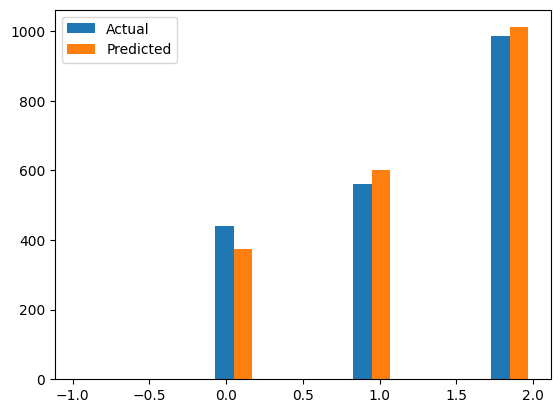

In [25]:
plt.hist([y_test, predictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

In [26]:
dfTest = pd.read_csv('postgres_validation_data.csv')


In [27]:
# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)


In [28]:
dfTest['mean'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTest[['count','unique','top','freq']] = dfTest.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTest['std'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTest['sum'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTest['min'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTest['max'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTest['median'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTest['slope'] = dfTest.apply(get_coeff, axis=1)
dfTest['var'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

In [29]:
# Drop the original 'rv' column
dfTest.drop(col_names, axis=1, inplace=True)

In [30]:
dfTest.head()

,tm,knt,ae,ae_cl,mean,count,unique,top,freq,std,sum,min,max,median,slope,var
0,2024-01-24 01:32:11.3875,1500,0.181943,0,1.865520,1500,3,2.0002,1297,0.341515,2798.2798,1.0001,2.0002,2.0002,-9.174255e-07,0.116633
1,2024-01-24 08:51:04.308806,1500,0.433016,1,20.676217,1500,4,20.7519,1386,0.326493,31014.3249,19.5312,21.9726,20.7519,-1.305314e-04,0.106598
2,2024-01-24 06:37:46.622796,1500,0.532427,1,1.864853,1500,3,2.0002,1296,0.342228,2797.2797,1.0001,2.0002,2.0002,-3.164229e-05,0.117120
3,2024-01-24 03:50:26.77633,1500,0.535184,1,2.395827,1500,4,2.4414,1429,0.259820,3593.7408,1.2207,3.6621,2.4414,-2.316835e-05,0.067507
4,2024-01-23 23:25:37.865158,1500,0.460215,1,1.865520,1500,3,2.0002,1297,0.341515,2798.2798,1.0001,2.0002,2.0002,3.002968e-05,0.116633


In [31]:
new_data = dfTest.loc[:, 'mean':'var'].astype(float).values
target_new_data = dfTest['ae_cl']

In [32]:
# Apply the same preprocessing steps to the new data
new_data_imputed = imputer.transform(new_data)
new_data_scaled = scaler.transform(new_data_imputed)

In [33]:
# Use the trained model to make predictions on the new data
new_data_predictions = best_model.predict(new_data_scaled)

In [34]:
newPredictionsRound = np.around(new_data_predictions, decimals=0)

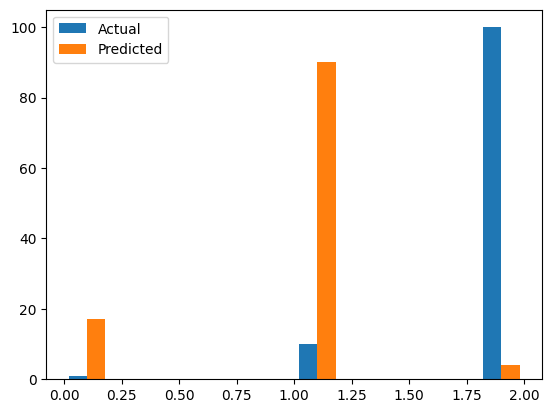

In [35]:
plt.hist([target_new_data, newPredictionsRound], label=['Actual', 'Predicted'])
plt.legend()
plt.show()

# MLP TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
dfTraining.head()

,tm,knt,ae,ae_cl,rv
0,2023-05-08 16:09:16.771572,1500,0.326013,0,"3.6620999999999997, 3.6620999999999997, 3.6620..."
1,2023-12-07 05:17:16.98583,1500,0.317388,0,"9.7656, 9.7656, 9.7656, 9.7656, 9.7656, 9.7656..."
2,2023-12-07 12:29:06.618496,1500,0.249031,0,"13.427699999999998, 14.648399999999999, 13.427..."
3,2023-12-08 01:46:33.934387,1500,0.339904,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."
4,2023-12-08 01:46:35.315528,1500,0.264804,0,"4.0004, 4.0004, 4.0004, 4.0004, 4.0004, 4.0004..."


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


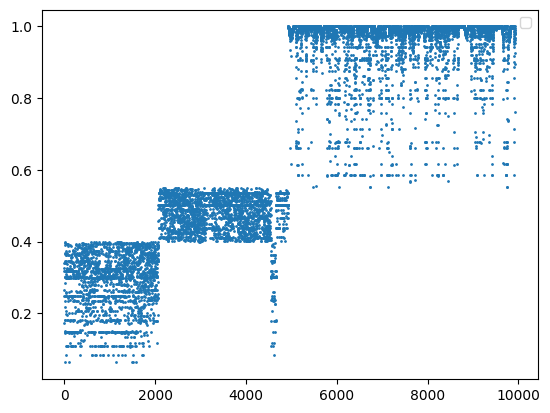

In [3]:
plt.scatter(dfTraining.index,dfTraining['ae'],s = 1)
plt.legend()
plt.show()

In [4]:
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)


In [7]:
modelLR = LinearRegression()
def get_coeff(row, model=model):
    # Select only relevant columns
    row = row.loc["rv1":"rv1500"]
    # Drop NaN values
    row = row.dropna()
    if len(row) > 1:  # Check if there are enough data points for regression
        X = np.arange(len(row)).reshape(-1, 1)
        y = row.values.reshape(-1, 1)
        modelLR.fit(X, y)
        slope = model.coef_[0][0]
        return slope
    else:
        return np.nan  # Return 


In [6]:
dfTraining['mean'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTraining[['count','unique','top','freq']] = dfTraining.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTraining['std'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTraining['sum'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTraining['min'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTraining['max'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTraining['median'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTraining['slope'] = dfTraining.apply(get_coeff, axis=1)
dfTraining['var'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

In [8]:
# Drop the original 'rv' column
dfTraining.drop(col_names, axis=1, inplace=True)

In [12]:
dfTraining.head()

,tm,knt,ae,ae_cl,mean,count,unique,top,freq,std,sum,min,max,median,slope,var
0,2023-05-08 16:09:16.771572,1500,0.326013,0,6.582014,1500,26,2.4414,743,41.679464,9873.0216,0.0000,717.7716,2.4414,0.006187,1737.177726
1,2023-12-07 05:17:16.98583,1500,0.317388,0,9.768855,1500,3,9.7656,1495,0.062974,14653.2828,9.7656,10.9863,9.7656,-0.000004,0.003966
2,2023-12-07 12:29:06.618496,1500,0.249031,0,14.459598,1500,3,14.648399999999999,1268,0.441536,21689.3976,13.4277,14.6484,14.6484,0.000030,0.194954
3,2023-12-08 01:46:33.934387,1500,0.339904,0,5.238524,1500,5,5.0005,653,0.745993,7857.7857,4.0004,7.0007,5.0005,0.001122,0.556505
4,2023-12-08 01:46:35.315528,1500,0.264804,0,5.382538,1500,5,5.0005,729,0.743340,8073.8073,4.0004,7.0007,5.0005,0.000977,0.552555


In [13]:
X = dfTraining.loc[:, 'mean':'var'].astype(float).values
y = dfTraining['ae']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2

In [74]:
# Define the model
model = Sequential()

model.add(Dense(64, input_dim=12, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(32, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(16, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(8, activation=LeakyReLU(alpha=0.01)))
model.add(Dense(1, activation='sigmoid'))

In [75]:
# Custom learning rate schedule for RMSprop optimizer
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 0.8  # decrease learning rate by 20% every 10 epochs
    return lr

custom_optimizer = RMSprop(learning_rate=0.0005)  # Adjust the learning rate
lr_scheduler = LearningRateScheduler(lr_schedule)


In [76]:
# Compile the model
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['mae'])


In [77]:
# Early stopping based on validation MAE
#early_stopping = EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_data=(X_test, y_test), callbacks=[lr_scheduler])



Epoch 1/300
125/125 [==============================] - 1s 3ms/step - loss: 1912.9823 - mae: 0.3879 - val_loss: 14.3958 - val_mae: 0.2783 - lr: 5.0000e-04
Epoch 2/300
125/125 [==============================] - 0s 2ms/step - loss: 419.9474 - mae: 0.4236 - val_loss: 388.9437 - val_mae: 0.3087 - lr: 5.0000e-04
Epoch 3/300
125/125 [==============================] - 0s 2ms/step - loss: 229.9529 - mae: 0.4325 - val_loss: 3.2213 - val_mae: 0.3758 - lr: 5.0000e-04
Epoch 4/300
125/125 [==============================] - 0s 2ms/step - loss: 26.1016 - mae: 0.4110 - val_loss: 0.6813 - val_mae: 0.2855 - lr: 5.0000e-04
Epoch 5/300
125/125 [==============================] - 0s 3ms/step - loss: 11.7864 - mae: 0.3530 - val_loss: 1.0266 - val_mae: 0.2588 - lr: 5.0000e-04
Epoch 6/300
125/125 [==============================] - 0s 2ms/step - loss: 8.4738 - mae: 0.3076 - val_loss: 1.4873 - val_mae: 0.2450 - lr: 5.0000e-04
Epoch 7/300
125/125 [==============================] - 0s 3ms/step - loss: 3.8750 - mae:

In [64]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

63/63 [==============================] - 0s 2ms/step - loss: 0.4617 - mae: 0.1019
Test Loss: 0.46168482303619385, Test MAE: 0.10188506543636322


In [65]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 1ms/step


In [66]:

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

Root Mean Squared Error on the test set: 0.14700234137465815
R-squared on the test set: 0.7542672829483192


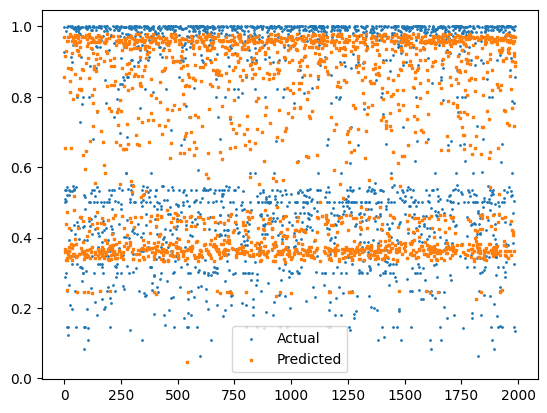

In [67]:
plt.scatter( [n + 1 for n in range(len(y_test))], y_test,s = 1, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(predictions))],predictions,s = 1, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

In [23]:
dfTest = pd.read_csv('postgres_validation_data.csv')
# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest['mean'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTest[['count','unique','top','freq']] = dfTest.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTest['std'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTest['sum'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTest['min'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTest['max'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTest['median'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTest['slope'] = dfTest.apply(get_coeff, axis=1)
dfTest['var'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

# Drop the original 'rv' column
dfTest.drop(col_names, axis=1, inplace=True)


In [56]:
new_data = dfTest.loc[:, 'mean':'var'].astype(float).values
target_new_data = dfTest['ae']

In [57]:
new_data = scaler.fit_transform(new_data)

In [68]:
new_data_predictions = model.predict(new_data)

4/4 [==============================] - 0s 728us/step


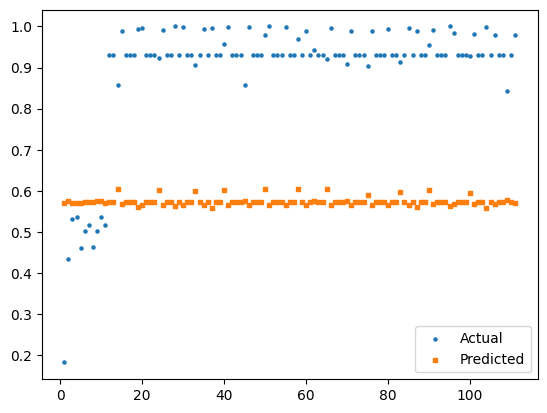

In [69]:
plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

# Altri modelli

In [32]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


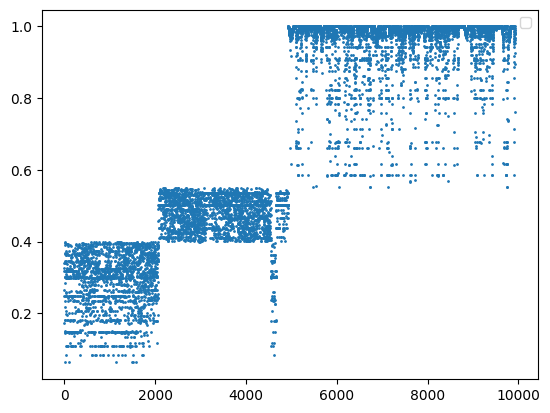

In [170]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
dfTraining.head()
plt.scatter(dfTraining.index,dfTraining['ae'],s = 1)
plt.legend()
plt.show()
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)
model = LinearRegression()
def get_coeff(row, model=model):
    # Select only relevant columns
    row = row.loc["rv1":"rv1500"]
    # Drop NaN values
    row = row.dropna()
    if len(row) > 1:  # Check if there are enough data points for regression
        X = np.arange(len(row)).reshape(-1, 1)
        y = row.values.reshape(-1, 1)
        model.fit(X, y)
        slope = model.coef_[0][0]
        return slope
    else:
        return np.nan  # Return 

dfTraining['mean'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTraining[['count','unique','top','freq']] = dfTraining.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTraining['std'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTraining['sum'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTraining['min'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTraining['max'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTraining['median'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTraining['slope'] = dfTraining.apply(get_coeff, axis=1)
dfTraining['var'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

# Drop the original 'rv' column
dfTraining.drop(col_names, axis=1, inplace=True)

dfTraining.head()

X = dfTraining.loc[:, 'mean':'var'].astype(float).values
y = dfTraining['ae']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
dfTest = pd.read_csv('postgres_validation_data.csv')
# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest['mean'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTest[['count','unique','top','freq']] = dfTest.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTest['std'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTest['sum'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTest['min'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTest['max'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTest['median'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTest['slope'] = dfTest.apply(get_coeff, axis=1)
dfTest['var'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

# Drop the original 'rv' column
dfTest.drop(col_names, axis=1, inplace=True)

new_data = dfTest.loc[:, 'mean':'var'].astype(float).values
target_new_data = dfTest['ae']

new_data = scaler.fit_transform(new_data)


## Random Forest Regressor

In [33]:
# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, rf_predictions)

print(f'Random Forest MAE: {mae}')

Random Forest MAE: 0.06621897044791142


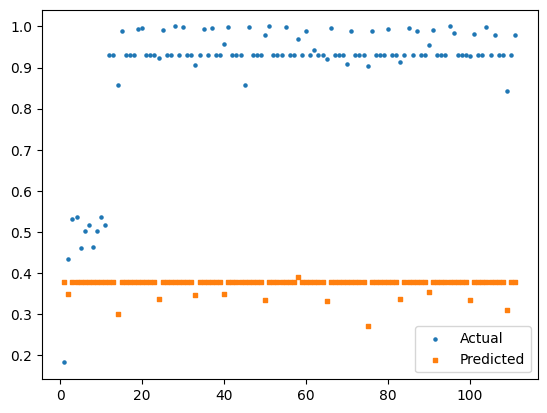

In [34]:
new_data_predictions = rf_model.predict(new_data)

plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

## XGBoost Regressor

In [35]:
# Create an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, xgb_predictions)

print(f'XGBoost MAE: {mae}')

XGBoost MAE: 0.07068315686630086


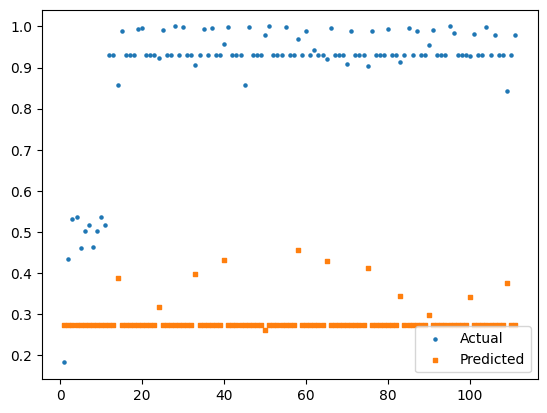

In [178]:
new_data_predictions = xgb_model.predict(new_data)

plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

## SVR

In [179]:
# Create an SVR model
svr_model = SVR(kernel='linear', C=1.0)

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions
svr_predictions = svr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, svr_predictions)

print(f'SVR MAE: {mae}')

SVR MAE: 13847.455567944528


In [184]:
new_data_predictions = svr_model.predict(new_data)



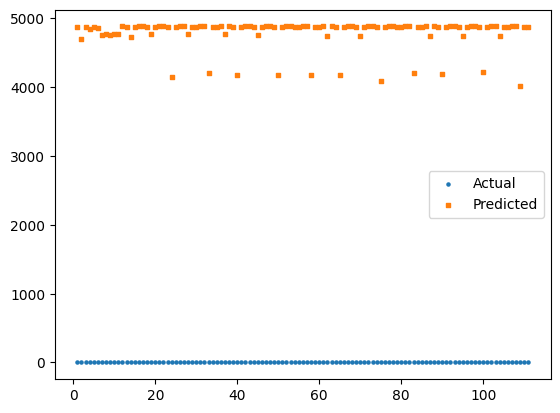

In [185]:

plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()


# Analisi dati

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)

In [3]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [43]:
rv = dfTraining.loc[8000,"rv1":"rv1500"].astype(float).to_numpy()

In [46]:
dfTraining

,tm,knt,ae,ae_cl,rv1,rv2,rv3,rv4,rv5,rv6,...,rv1491,rv1492,rv1493,rv1494,rv1495,rv1496,rv1497,rv1498,rv1499,rv1500
0,2023-05-08 16:09:16.771572,1500,0.326013,0,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,2.4414,...,3.6620999999999997,2.4414,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997,3.6620999999999997
1,2023-12-07 05:17:16.98583,1500,0.317388,0,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656,...,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656,9.7656
2,2023-12-07 12:29:06.618496,1500,0.249031,0,13.427699999999998,14.648399999999999,13.427699999999998,13.427699999999998,13.427699999999998,14.648399999999999,...,13.427699999999998,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999,14.648399999999999
3,2023-12-08 01:46:33.934387,1500,0.339904,0,4.0004,4.0004,4.0004,4.0004,4.0004,4.0004,...,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005
4,2023-12-08 01:46:35.315528,1500,0.264804,0,4.0004,4.0004,4.0004,4.0004,4.0004,4.0004,...,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005,5.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9927,2022-09-20 04:13:03.46475,1500,0.980339,2,27.0027,26.0026,26.0026,27.0027,27.0027,27.0027,...,26.0026,27.0027,27.0027,27.0027,26.0026,27.0027,27.0027,27.0027,27.0027,26.0026
9928,2022-09-20 04:16:08.638387,1500,0.979374,2,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,...,27.0027,26.0026,26.0026,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027
9929,2022-09-20 04:19:13.815312,1500,0.991370,2,27.0027,27.0027,26.0026,27.0027,27.0027,27.0027,...,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,26.0026,27.0027,27.0027
9930,2022-09-20 04:22:18.995324,1500,0.967481,2,27.0027,27.0027,27.0027,27.0027,27.0027,27.0027,...,26.0026,26.0026,26.0026,26.0026,27.0027,27.0027,26.0026,26.0026,26.0026,27.0027


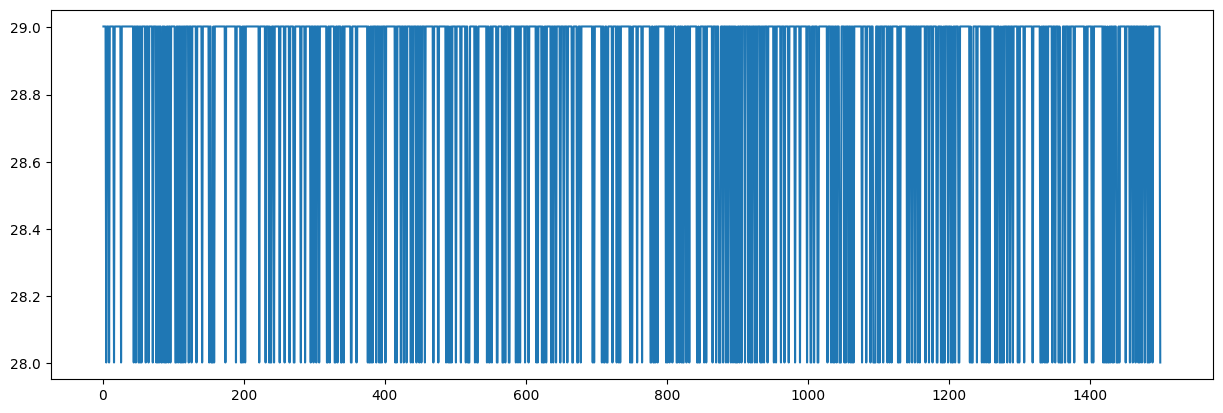

In [45]:
plt.figure().set_figwidth(15)
plt.plot(np.arange(1, len(rv)+1) ,rv)
plt.show()

# RNN

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [2]:
# Dati estrapolati dal db remoto di Giuliano in data 22/01/2024, solamente per le classi 0 e 1
df1 = pd.read_csv('postgres_dati_aggiornati.csv')

df2 = pd.read_csv('postgres_new_data.csv')

dfTraining = pd.concat([df1, df2], ignore_index=True)
#------------------------ Load and preprocess the data ------------------------

# Generate the column names as rv1, rv2, ..., rv1500
col_names = [f'rv{i}' for i in range(1, 1501)]

# Split the rv column by comma into a list of Series
split_series = dfTraining['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTraining = pd.concat([dfTraining, split_series], axis=1)

# Rename the split columns
dfTraining.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column
dfTraining.drop('rv', axis=1, inplace=True)

In [18]:
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()
def get_intercept(row, model=modelLR):
    row = row.loc["rv1":"rv1500"]
    row = row.dropna()
    if len(row) > 1:  # Check if there are enough data points for regression
        X = np.arange(len(row)).reshape(-1, 1)
        y = row.values.reshape(-1, 1)
        model.fit(X, y)
        return modelLR.intercept_[0]
    else:
        return np.nan  # Return 

def get_slope(row, model=modelLR):
    row = row.loc["rv1":"rv1500"]
    row = row.dropna()
    if len(row) > 1:  # Check if there are enough data points for regression
        X = np.arange(len(row)).reshape(-1, 1)
        y = row.values.reshape(-1, 1)
        model.fit(X, y)
        return model.coef_[0][0]
    else:
        return np.nan  # Return 


In [19]:
dfTraining['mean'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTraining[['count','unique','top','freq']] = dfTraining.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTraining['std'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTraining['sum'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTraining['min'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTraining['max'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTraining['median'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTraining['intercept'] = dfTraining.apply(get_intercept, axis=1)
dfTraining['slope'] = dfTraining.apply(get_slope, axis=1)
dfTraining['var'] = dfTraining.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

In [20]:
X = dfTraining.loc[:, 'mean':'var'].astype(float).values
y = dfTraining['ae']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))


In [26]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
249/249 [==============================] - 8s 20ms/step - loss: 0.0418 - mae: 0.1667
Epoch 2/100
249/249 [==============================] - 6s 24ms/step - loss: 0.0314 - mae: 0.1373
Epoch 3/100
249/249 [==============================] - 7s 27ms/step - loss: 0.0275 - mae: 0.1247
Epoch 4/100
249/249 [==============================] - 7s 27ms/step - loss: 0.0258 - mae: 0.1197
Epoch 5/100
249/249 [==============================] - 6s 26ms/step - loss: 0.0246 - mae: 0.1148
Epoch 6/100
249/249 [==============================] - 6s 25ms/step - loss: 0.0241 - mae: 0.1125
Epoch 7/100
249/249 [==============================] - 6s 25ms/step - loss: 0.0229 - mae: 0.1095
Epoch 8/100
249/249 [==============================] - 6s 25ms/step - loss: 0.0220 - mae: 0.1061
Epoch 9/100
249/249 [==============================] - 6s 26ms/step - loss: 0.0222 - mae: 0.1053
Epoch 10/100
249/249 [==============================] - 7s 30ms/step - loss: 0.0219 - mae: 0.1048
Epoch 11/100
249/249 [=======

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
predictions = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

#print(f"Best parameters: {best_params}")
print(f"Root Mean Squared Error on the test set: {rmse}")
print(f"R-squared on the test set: {r2}")

63/63 [==============================] - 1s 8ms/step
Root Mean Squared Error on the test set: 0.14112147957215823
R-squared on the test set: 0.7735351933425482


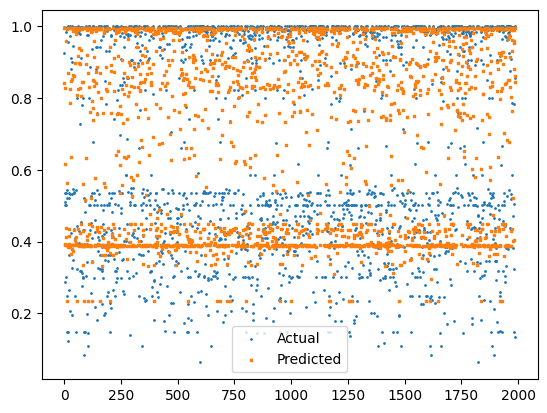

In [29]:
plt.scatter( [n + 1 for n in range(len(y_test))], y_test,s = 1, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(predictions))],predictions,s = 1, marker = 's', label = 'Predicted')
plt.legend()
plt.show()

4/4 [==============================] - 0s 7ms/step


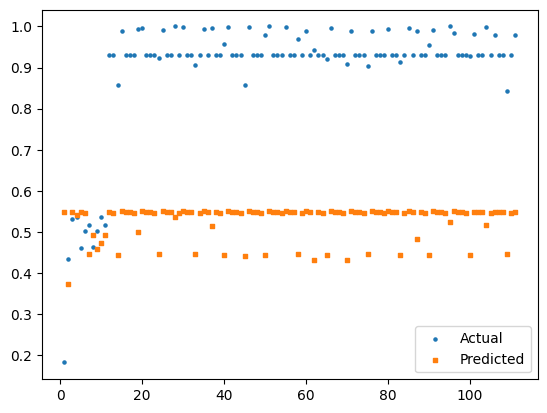

In [30]:
dfTest = pd.read_csv('postgres_validation_data.csv')
# Split the rv column by comma into a list of Series
split_series = dfTest['rv'].str.split(',', n=1499, expand=True).apply(pd.Series)

# Concatenate the original DataFrame with the split Series
dfTest = pd.concat([dfTest, split_series], axis=1)

# Rename the split columns
dfTest.rename(columns=dict(zip(split_series.columns, col_names)), inplace=True)

# Drop the original 'rv' column

# Drop the original 'rv' column
dfTest.drop('rv', axis=1, inplace=True)

dfTest['mean'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).mean(axis=1)
dfTest[['count','unique','top','freq']] = dfTest.loc[:,"rv1":"rv1500"].apply(pd.Series.describe, axis=1)
dfTest['std'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).std(axis=1)
dfTest['sum'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).sum(axis=1)
dfTest['min'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).min(axis=1)
dfTest['max'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).max(axis=1)
dfTest['median'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).median(axis=1)
dfTest['intercept'] = dfTest.apply(get_intercept, axis=1)
dfTest['slope'] = dfTest.apply(get_slope, axis=1)
dfTest['var'] = dfTest.loc[:,"rv1":"rv1500"].astype(float).var(axis=1)

# Drop the original 'rv' column
dfTest.drop(col_names, axis=1, inplace=True)

new_data = dfTest.loc[:, 'mean':'var'].astype(float).values
target_new_data = dfTest['ae']

new_data = scaler.fit_transform(new_data)

new_data_predictions = model.predict(new_data)

plt.scatter( [n + 1 for n in range(len(target_new_data))], target_new_data,s = 5, marker = 'o', label = 'Actual')
plt.scatter([n + 1 for n in range(len(new_data_predictions))],new_data_predictions,s = 5, marker = 's', label = 'Predicted')
plt.legend()
plt.show()